# Baby N-Neuron Multi-Timescale RNN

**Goal**: Investigate how different timescales (α) affect a teacher-student learning setup.

We implement a minimal N-neuron RNN with the update rule:
$$r^j_{t+1} = (1 - \alpha^j) r^j_t + \alpha^j \phi(W_{rec} r_t + b)^j$$

where:
- $r \in \mathbb{R}^N$ is the hidden state
- $\alpha \in (0,1)^N$ are per-neuron timescale parameters
- $W_{rec} \in \mathbb{R}^{N \times N}$ is the recurrent weight matrix
- $b \in \mathbb{R}^N$ is the bias vector
- $\phi$ is Tanh or ReLU

**Experiment**: Train a student network (with different α than teacher) to match teacher trajectories by only learning $W_{rec}$ and $b$.

**Visualization**: 2D phase portraits for N=2, 3D phase portraits for N=3.

## 1. Setup and Imports

In [67]:
from typing import Callable
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 12

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [128]:
class BabyRNN(nn.Module):
    """
    Minimal N-neuron multi-timescale RNN (no external input).
    
    Update rule: r_{t+1} = (1 - α) * r_t + α * φ(W_rec @ r_t + b)
    """
    
    def __init__(
        self,
        num_neurons: int,
        alphas: torch.Tensor,
        activation: type[nn.Module] = nn.Tanh,
        zero_diag: bool = False,
    ) -> None:
        """
        Args:
            num_neurons: Number of neurons in the RNN.
            alphas: Per-neuron timescale parameters, shape (num_neurons,), values in (0, 1).
            activation: Activation function class (nn.Tanh or nn.ReLU).
            zero_diag: If True, freeze diagonal of W_rec to 0.
        """
        super().__init__()
        
        # Store alphas as a buffer (frozen, not trained)
        self.register_buffer("alphas", alphas.clone())

        self.num_neurons = num_neurons
        
        # Recurrent weights: W_rec @ r + b
        self.W_rec = nn.Linear(num_neurons, num_neurons, bias=True)
        
        # Activation function
        self.activation = activation()
        
        # Optional: zero diagonal constraint
        self.zero_diag = zero_diag
        if zero_diag:
            self.W_rec.weight.data.fill_diagonal_(0)
            self.W_rec.weight.register_hook(lambda g: g.clone().fill_diagonal_(0))
    
    def forward(self, r: torch.Tensor) -> torch.Tensor:
        """
        One-step update: r_{t+1} = (1 - α) * r_t + α * φ(W_rec @ r_t + b)
        
        Args:
            r: Hidden state, shape (..., 2)
        Returns:
            New hidden state, shape (..., 2)
        """
        pre_activation = self.W_rec(r)
        activated = self.activation(pre_activation)
        return (1 - self.alphas) * r + self.alphas * activated
    
    def delta(self, r: torch.Tensor) -> torch.Tensor:
        """
        Compute δr = r_{t+1} - r_t = α * (-r + φ(W_rec @ r + b))
        
        Args:
            r: Hidden state, shape (..., 2)
        Returns:
            Change in state, shape (..., 2)
        """
        pre_activation = self.W_rec(r)
        activated = self.activation(pre_activation)
        return self.alphas * (-r + activated)
    
    def unroll(self, r0: torch.Tensor, T: int) -> torch.Tensor:
        """
        Unroll the RNN for T steps.
        
        Args:
            r0: Initial state, shape (batch, 2)
            T: Number of time steps
        Returns:
            Trajectory, shape (batch, T+1, 2) including initial state
        """
        batch_size = r0.shape[0]

        trajectory = torch.zeros(batch_size, T + 1, self.num_neurons, device=r0.device)
        trajectory[:, 0] = r0
        
        r = r0
        for t in range(T):
            r = self.forward(r)
            trajectory[:, t + 1] = r
        
        return trajectory
    
    def copy_weights_from(self, other: "BabyRNN") -> None:
        """Copy W_rec and bias from another BabyRNN (keeping own alphas)."""
        self.W_rec.weight.data.copy_(other.W_rec.weight.data)
        self.W_rec.bias.data.copy_(other.W_rec.bias.data)


# Quick test
test_alphas = torch.tensor([0.3, 0.7, 0.5])
NUM_NEURONS = len(test_alphas)
test_rnn = BabyRNN(NUM_NEURONS, test_alphas, activation=nn.Tanh)
test_r = torch.randn(4, NUM_NEURONS)
print(f"Input shape: {test_r.shape}")
print(f"Output shape: {test_rnn(test_r).shape}")
print(f"Delta shape: {test_rnn.delta(test_r).shape}")
print(f"Unroll shape: {test_rnn.unroll(test_r, T=10).shape}")
print(f"\nAlphas: {test_rnn.alphas}")
print(f"W_rec:\n{test_rnn.W_rec.weight.data}")
print(f"Bias: {test_rnn.W_rec.bias.data}")

Input shape: torch.Size([4, 3])
Output shape: torch.Size([4, 3])
Delta shape: torch.Size([4, 3])
Unroll shape: torch.Size([4, 11, 3])

Alphas: tensor([0.3000, 0.7000, 0.5000])
W_rec:
tensor([[-0.2458,  0.5173, -0.2888],
        [-0.0498,  0.5321,  0.2498],
        [-0.1721, -0.3464, -0.1498]])
Bias: tensor([ 0.3945, -0.4569, -0.4679])


## 3. Phase Portrait Visualization


In [238]:
def plot_phase_portrait_2d(
    rnn: BabyRNN,
    ax: plt.Axes,
    xlim: tuple[float, float] = (-2, 2),
    ylim: tuple[float, float] = (-2, 2),
    n_grid: int = 25,
    normalize_arrows: bool = True,
    trajectories: list[torch.Tensor] | None = None,
    title: str = "Phase Portrait",
) -> None:
    """
    Plot the vector field δr for a 2-neuron BabyRNN on a 2D grid.
    
    Args:
        rnn: The BabyRNN model (must have num_neurons=2).
        ax: Matplotlib 2D axes.
        xlim: Range for r1.
        ylim: Range for r2.
        n_grid: Number of grid points per dimension.
        normalize_arrows: If True, normalize to unit vectors.
        trajectories: Optional list of trajectories to overlay.
        title: Plot title.
    """
    assert rnn.num_neurons == 2, "2D plot requires num_neurons=2"
    
    # Create grid
    r1 = np.linspace(xlim[0], xlim[1], n_grid)
    r2 = np.linspace(ylim[0], ylim[1], n_grid)
    R1, R2 = np.meshgrid(r1, r2)
    
    # Flatten and convert to tensor
    r_grid = torch.tensor(
        np.stack([R1.flatten(), R2.flatten()], axis=1),
        dtype=torch.float32
    )
    
    # Compute delta
    with torch.no_grad():
        delta = rnn.delta(r_grid).numpy()
    
    U = delta[:, 0].reshape(R1.shape)
    V = delta[:, 1].reshape(R1.shape)
    
    # Optionally normalize to unit vectors
    if normalize_arrows:
        speed = np.sqrt(U**2 + V**2)
        speed[speed == 0] = 1.0
        U = U / speed
        V = V / speed
    
    # Quiver plot
    ax.quiver(
        R1, R2, U, V,
        angles="xy",
        scale_units="xy",
        scale=3,
        width=0.003,
        headwidth=4,
        headlength=3,
        alpha=0.7,
    )
    
    # Overlay trajectories if provided
    if trajectories is not None:
        colors = plt.cm.viridis(np.linspace(0, 1, len(trajectories)))
        for traj, color in zip(trajectories, colors):
            traj_np = traj.numpy()
            ax.plot(traj_np[:, 0], traj_np[:, 1], "-", color=color, linewidth=1.5, alpha=0.8)
            ax.scatter(traj_np[0, 0], traj_np[0, 1], s=50, color=color, marker="o", zorder=5)
            ax.scatter(traj_np[-1, 0], traj_np[-1, 1], s=50, color=color, marker="x", zorder=5)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r"$r_1$", fontsize=12)
    ax.set_ylabel(r"$r_2$", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_aspect("equal")
    ax.grid(True, alpha=0.3)


def plot_phase_portrait_3d(
    rnn: BabyRNN,
    ax: Axes3D,
    lim: tuple[float, float] = (-3, 3),
    n_grid: int = 8,
    normalize_arrows: bool = True,
    trajectories: list[torch.Tensor] | None = None,
    title: str = "3D Phase Portrait",
) -> None:
    """
    Plot the vector field δr for a 3-neuron BabyRNN in 3D.
    
    Args:
        rnn: The BabyRNN model (must have num_neurons=3).
        ax: Matplotlib 3D axes.
        lim: Range for all axes (r1, r2, r3).
        n_grid: Number of grid points per dimension (keep small for clarity).
        normalize_arrows: If True, normalize to unit vectors.
        trajectories: Optional list of trajectories to overlay.
        title: Plot title.
    """
    assert rnn.num_neurons == 3, "3D plot requires num_neurons=3"
    
    # Create 3D grid
    r1 = np.linspace(lim[0], lim[1], n_grid)
    r2 = np.linspace(lim[0], lim[1], n_grid)
    r3 = np.linspace(lim[0], lim[1], n_grid)
    R1, R2, R3 = np.meshgrid(r1, r2, r3, indexing='ij')
    
    # Flatten and convert to tensor
    r_grid = torch.tensor(
        np.stack([R1.flatten(), R2.flatten(), R3.flatten()], axis=1),
        dtype=torch.float32
    )
    
    # Compute delta
    with torch.no_grad():
        delta = rnn.delta(r_grid).numpy()
    
    U = delta[:, 0]
    V = delta[:, 1]
    W = delta[:, 2]
    
    # Optionally normalize to unit vectors
    if normalize_arrows:
        speed = np.sqrt(U**2 + V**2 + W**2)
        speed[speed == 0] = 1.0
        U = U / speed
        V = V / speed
        W = W / speed
    
    # 3D quiver plot
    ax.quiver(
        R1.flatten(), R2.flatten(), R3.flatten(),
        U, V, W,
        length=0.3,
        normalize=False,
        alpha=0.5,
        arrow_length_ratio=0.3,
    )
    
    # Overlay trajectories if provided
    if trajectories is not None:
        colors = plt.cm.viridis(np.linspace(0, 1, len(trajectories)))
        for traj, color in zip(trajectories, colors):
            traj_np = traj.numpy()
            ax.plot3D(traj_np[:, 0], traj_np[:, 1], traj_np[:, 2], 
                     "-", color=color, linewidth=2, alpha=0.9)
            ax.scatter3D(traj_np[0, 0], traj_np[0, 1], traj_np[0, 2], 
                        s=80, color=color, marker="o")
            ax.scatter3D(traj_np[-1, 0], traj_np[-1, 1], traj_np[-1, 2], 
                        s=80, color=color, marker="x")
    
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_zlim(lim)
    ax.set_xlabel(r"$r_1$", fontsize=12)
    ax.set_ylabel(r"$r_2$", fontsize=12)
    ax.set_zlabel(r"$r_3$", fontsize=12)
    ax.set_title(title, fontsize=14)


def plot_phase_portrait(
    rnn: BabyRNN,
    ax,
    trajectories: list[torch.Tensor] | None = None,
    title: str = "Phase Portrait",
    **kwargs,
) -> None:
    """
    Unified phase portrait function that dispatches to 2D or 3D based on num_neurons.
    """
    if rnn.num_neurons == 2:
        plot_phase_portrait_2d(rnn, ax, trajectories=trajectories, title=title, **kwargs)
    elif rnn.num_neurons == 3:
        plot_phase_portrait_3d(rnn, ax, trajectories=trajectories, title=title, **kwargs)
    else:
        raise ValueError(f"Phase portrait only supports 2 or 3 neurons, got {rnn.num_neurons}")

In [130]:
# Create a teacher network and visualize its phase portrait
torch.manual_seed(123)

# Teacher with random alphas
teacher_alphas = torch.rand(NUM_NEURONS) * 0.8 + 0.1  # Uniform in (0.1, 0.9)
teacher_tanh = BabyRNN(NUM_NEURONS, teacher_alphas, activation=nn.Tanh)
teacher_relu = BabyRNN(NUM_NEURONS, teacher_alphas, activation=nn.ReLU)

# Copy same weights to ReLU version for fair comparison
teacher_relu.W_rec.weight.data.copy_(teacher_tanh.W_rec.weight.data)
teacher_relu.W_rec.bias.data.copy_(teacher_tanh.W_rec.bias.data)

print(f"Teacher alphas: {teacher_alphas}")
print(f"Teacher W_rec:\n{teacher_tanh.W_rec.weight.data}")
print(f"Teacher bias: {teacher_tanh.W_rec.bias.data}")

Teacher alphas: tensor([0.3369, 0.5132, 0.3013])
Teacher W_rec:
tensor([[ 0.2177, -0.4919,  0.4232],
        [-0.4196, -0.4590, -0.3648],
        [ 0.2615, -0.2133,  0.2161]])
Teacher bias: tensor([-0.4900, -0.3503, -0.2120])


## 4. Teacher-Student Training


### Hand-Picked 2-Neuron Network

Manually set W and b to explore specific dynamics.

Custom 2-neuron network:
Alphas: [0.5 0.3]
W_rec:
[[-0.116     -3.5400002]
 [ 3.5400002 -0.116    ]]
Bias: [ 1.83 -2.2 ]


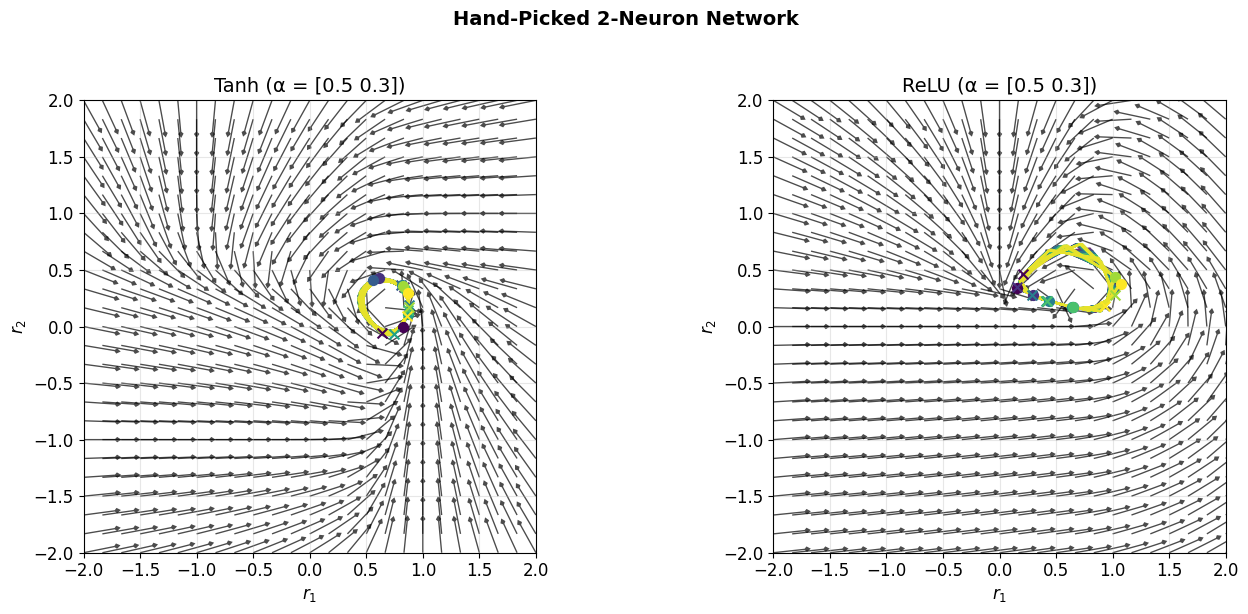

In [229]:
# === Hand-picked 2-neuron network ===

# Timescales (α ∈ (0, 1))
custom_alphas = torch.tensor([0.5, 0.3])

# # Recurrent weights W_rec (2x2 matrix)
# # W[i,j] = connection from neuron j to neuron i
# custom_W = 2*torch.tensor([
#     [0, -1],   # connections TO neuron 0
#     [1, 0],   # connections TO neuron 1
# ], dtype=torch.float32)

# # Bias
# #custom_b = torch.tensor([-1.0, -1.0], dtype=torch.float32)
# custom_b = torch.tensor([0.0, 0.0], dtype=torch.float32)


# Recurrent weights W_rec (2x2 matrix)
# (roughly: rotation + mild self-damping)
custom_W = 0.4*torch.tensor([
    [-0.29, -8.85],
    [ 8.85, -0.29],
], dtype=torch.float32)

# Bias (breaks symmetry + creates regime switching)
custom_b = torch.tensor([ 1.83, -2.20], dtype=torch.float32)


# Create networks with Tanh and ReLU
custom_tanh = BabyRNN(2, custom_alphas, activation=nn.Tanh)
custom_relu = BabyRNN(2, custom_alphas, activation=nn.ReLU)

# Set custom weights
custom_tanh.W_rec.weight.data = custom_W.clone()
custom_tanh.W_rec.bias.data = custom_b.clone()
custom_relu.W_rec.weight.data = custom_W.clone()
custom_relu.W_rec.bias.data = custom_b.clone()

print("Custom 2-neuron network:")
print(f"Alphas: {custom_alphas.numpy()}")
print(f"W_rec:\n{custom_W.numpy()}")
print(f"Bias: {custom_b.numpy()}")



# Generate trajectories from random initial conditions
torch.manual_seed(42)
n_traj = 8
r0_custom = torch.randn(n_traj, 2) * 0.7
T_custom = 100

lag = 20

with torch.no_grad():
    trajs_custom_tanh = [custom_tanh.unroll(r0_custom[i:i+1], T_custom).squeeze(0)[lag:] for i in range(n_traj)]
    trajs_custom_relu = [custom_relu.unroll(r0_custom[i:i+1], T_custom).squeeze(0)[lag:] for i in range(n_traj)]

# Plot 2D phase portraits
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

xlim = (-2,2)
ylim = (-2,2)

plot_phase_portrait_2d(
    custom_tanh, axes[0],
    xlim=xlim, ylim=ylim,
    trajectories=trajs_custom_tanh,
    title=f"Tanh (α = {custom_alphas.numpy()})"
)

plot_phase_portrait_2d(
    custom_relu, axes[1],
    xlim=xlim, ylim=ylim,
    trajectories=trajs_custom_relu,
    title=f"ReLU (α = {custom_alphas.numpy()})"
)

plt.suptitle("Hand-Picked 2-Neuron Network", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

In [250]:
def train_student(
    teacher: BabyRNN,
    student: BabyRNN,
    n_epochs: int = 500,
    batch_size: int = 64,
    T: int = 50,
    lr: float = 1e-2,
    init_scale: float = 2.0,
    lag: int = 0,
) -> list[float]:
    """
    Train student to match teacher trajectories by learning W_rec and bias.
    
    Args:
        teacher: Frozen teacher network.
        student: Student network (same architecture, different alphas).
        n_epochs: Number of training epochs.
        batch_size: Number of random initial conditions per batch.
        T: Trajectory length.
        lr: Learning rate.
        init_scale: Scale for random initial conditions.
        lag: Burn-in period — skip first `lag` timesteps when computing loss
             (useful for letting transients die out before measuring steady-state).
    
    Returns:
        List of losses per epoch.
    """
    num_neurons = teacher.num_neurons
    
    # Only train W_rec weights and bias
    optimizer = torch.optim.Adam(student.W_rec.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
    
    losses = []
    
    for epoch in range(n_epochs):
        # Random initial conditions
        r0 = torch.randn(batch_size, num_neurons) * init_scale
        
        # Unroll both networks
        with torch.no_grad():
            teacher_traj = teacher.unroll(r0, T)  # (batch, T+1, num_neurons)
        
        student_traj = student.unroll(r0, T)  # (batch, T+1, num_neurons)
        
        # MSE loss over trajectory (after burn-in)
        loss = mse_loss(student_traj[:, lag:, :], teacher_traj[:, lag:, :])
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1:4d} | Loss: {loss.item():.6f}")
    
    return losses


def train_student_vectorfield(
    teacher: BabyRNN,
    student: BabyRNN,
    n_epochs: int = 500,
    n_samples: int = 256,
    sample_scale: float = 3.0,
    lr: float = 1e-2,
) -> list[float]:
    """
    Train student to match teacher's vector field directly.
    
    Instead of matching trajectories, we sample random points in state space
    and minimize the difference in the vector field δr = f(r) - r.
    
    Args:
        teacher: Frozen teacher network.
        student: Student network (same architecture, different alphas).
        n_epochs: Number of training epochs.
        n_samples: Number of random state-space points per batch.
        sample_scale: Scale for random state sampling (std of Gaussian).
        lr: Learning rate.
    
    Returns:
        List of losses per epoch.
    """
    optimizer = torch.optim.Adam(student.W_rec.parameters(), lr=lr)
    mse_loss = nn.MSELoss()
    losses = []
    
    for epoch in range(n_epochs):
        # Sample random points in state space
        r = torch.randn(n_samples, teacher.num_neurons) * sample_scale
        
        # Compute vector fields: δr = f(r) - r
        with torch.no_grad():
            teacher_delta = teacher(r) - r
        
        student_delta = student(r) - r
        
        loss = mse_loss(student_delta, teacher_delta)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch+1:4d} | VF Loss: {loss.item():.6f}")
    
    return losses

In [202]:
def create_teacher_student_pair(
    num_neurons: int,
    activation: type[nn.Module],
    teacher_seed: int = 42,
    student_alpha_seed: int = 123,
    zero_diag: bool = True,
    # Optional hand-picked values (override random init)
    custom_W: torch.Tensor | None = None,
    custom_b: torch.Tensor | None = None,
    custom_teacher_alphas: torch.Tensor | None = None,
    custom_student_alphas: torch.Tensor | None = None,
) -> tuple[BabyRNN, BabyRNN]:
    """
    Create a teacher-student pair with:
    - Same W_rec and bias initialization
    - Different alphas
    
    Args:
        num_neurons: Number of neurons in the RNN.
        activation: Activation function class.
        teacher_seed: Random seed for teacher initialization (ignored if custom values provided).
        student_alpha_seed: Random seed for student alpha initialization (ignored if custom provided).
        zero_diag: Whether to zero the diagonal of the recurrent weight matrix.
        custom_W: Optional hand-picked recurrent weight matrix, shape (num_neurons, num_neurons).
        custom_b: Optional hand-picked bias vector, shape (num_neurons,).
        custom_teacher_alphas: Optional hand-picked teacher alphas, shape (num_neurons,).
        custom_student_alphas: Optional hand-picked student alphas, shape (num_neurons,).
    
    Returns:
        (teacher, student) tuple.
    """

    zero_diag = True
    # Teacher alphas: custom or random
    if custom_teacher_alphas is not None:
        teacher_alphas = custom_teacher_alphas.clone()
    else:
        torch.manual_seed(teacher_seed)
        teacher_alphas = torch.rand(num_neurons) * 0.8 + 0.1  # (0.1, 0.9)
    
    teacher = BabyRNN(
        num_neurons, 
        teacher_alphas, 
        activation=activation,
        zero_diag=zero_diag,
        )
    
    # If custom W or b provided, override teacher's initialization
    if custom_W is not None:
        teacher.W_rec.weight.data = custom_W.clone()
    if custom_b is not None:
        teacher.W_rec.bias.data = custom_b.clone()
    
    # Student alphas: custom or random
    if custom_student_alphas is not None:
        student_alphas = custom_student_alphas.clone()
    else:
        torch.manual_seed(student_alpha_seed)
        student_alphas = torch.rand(num_neurons) * 0.8 + 0.1  # (0.1, 0.9)
    
    student = BabyRNN(
        num_neurons, 
        student_alphas, 
        activation=activation,
        zero_diag=zero_diag,
        )
    
    # Copy teacher's weights to student (so they start from same W_rec, b)
    student.copy_weights_from(teacher)
    
    return teacher, student


# Quick test (random init)
test_n = NUM_NEURONS
teacher_test, student_test = create_teacher_student_pair(test_n, nn.Tanh)
print(f"Teacher alphas: {teacher_test.alphas}")
print(f"Student alphas: {student_test.alphas}")
print(f"Weights match: {torch.allclose(teacher_test.W_rec.weight, student_test.W_rec.weight)}")

Teacher alphas: tensor([0.8058, 0.8320])
Student alphas: tensor([0.3369, 0.5132])
Weights match: True


## 5. Experiments: Tanh vs ReLU


In [242]:
# === CONFIGURATION ===
NUM_NEURONS = 2  # Set to 2 for 2D visualization, 3 for 3D

# Training hyperparameters
N_EPOCHS = 500
BATCH_SIZE = 64
T = 60
LR = 1e-2

# Seeds for reproducibility
TEACHER_SEED = 42
STUDENT_ALPHA_SEED = 123

CUSTOM_W = 0.4*torch.tensor([
    [-0.29, -8.85],
    [ 8.85, -0.29],
], dtype=torch.float32)

CUSTOM_B = torch.tensor([ 1.83, -2.20], dtype=torch.float32)


CUSTOM_TEACHER_ALPHAS = torch.tensor([0.5, 0.3])

CUSTOM_STUDENT_ALPHAS = torch.tensor([0.2, 0.9])

ZERO_DIAG = False

LAG = 20

In [243]:
print("=" * 60)
print(f"Training Tanh Student ({NUM_NEURONS} neurons)")
print("=" * 60)

teacher_tanh, student_tanh = create_teacher_student_pair(
    NUM_NEURONS, 
    nn.Tanh, 
    teacher_seed=TEACHER_SEED, 
    student_alpha_seed=STUDENT_ALPHA_SEED,
    zero_diag=ZERO_DIAG,
    custom_W=CUSTOM_W,
    custom_b=CUSTOM_B,
    custom_teacher_alphas=CUSTOM_TEACHER_ALPHAS,
    custom_student_alphas=CUSTOM_STUDENT_ALPHAS
)

print(f"Teacher alphas: {teacher_tanh.alphas.numpy()}")
print(f"Student alphas: {student_tanh.alphas.numpy()}")
print()

losses_tanh = train_student(
    teacher_tanh, 
    student_tanh,
    n_epochs=N_EPOCHS, 
    batch_size=BATCH_SIZE, 
    T=T, 
    lr=LR,
    lag=LAG,
)

Training Tanh Student (2 neurons)
Teacher alphas: [0.5 0.3]
Student alphas: [0.2 0.9]

Epoch   20 | Loss: 0.029178
Epoch   40 | Loss: 0.028458
Epoch   60 | Loss: 0.028501
Epoch   80 | Loss: 0.027951
Epoch  100 | Loss: 0.027532
Epoch  120 | Loss: 0.027549
Epoch  140 | Loss: 0.027489
Epoch  160 | Loss: 0.027263
Epoch  180 | Loss: 0.027379
Epoch  200 | Loss: 0.027288
Epoch  220 | Loss: 0.027260
Epoch  240 | Loss: 0.027198
Epoch  260 | Loss: 0.027255
Epoch  280 | Loss: 0.027207
Epoch  300 | Loss: 0.027267
Epoch  320 | Loss: 0.027223
Epoch  340 | Loss: 0.027248
Epoch  360 | Loss: 0.027276
Epoch  380 | Loss: 0.027277
Epoch  400 | Loss: 0.027239
Epoch  420 | Loss: 0.027298
Epoch  440 | Loss: 0.027209
Epoch  460 | Loss: 0.027238
Epoch  480 | Loss: 0.027299
Epoch  500 | Loss: 0.027185


In [244]:
# Create and train ReLU networks
print("=" * 60)
print(f"Training ReLU Student ({NUM_NEURONS} neurons)")
print("=" * 60)

teacher_relu, student_relu = create_teacher_student_pair(
    NUM_NEURONS, 
    nn.ReLU, 
    teacher_seed=TEACHER_SEED, 
    student_alpha_seed=STUDENT_ALPHA_SEED,
    custom_W=CUSTOM_W,
    custom_b=CUSTOM_B,
    custom_teacher_alphas=CUSTOM_TEACHER_ALPHAS,
    custom_student_alphas=CUSTOM_STUDENT_ALPHAS
)

print(f"Teacher alphas: {teacher_relu.alphas.numpy()}")
print(f"Student alphas: {student_relu.alphas.numpy()}")
print()

losses_relu = train_student(
    teacher_relu, 
    student_relu,
    n_epochs=N_EPOCHS, 
    batch_size=BATCH_SIZE, 
    T=T, 
    lr=LR,
    lag = LAG,
)

Training ReLU Student (2 neurons)
Teacher alphas: [0.5 0.3]
Student alphas: [0.2 0.9]

Epoch   20 | Loss: 0.155459
Epoch   40 | Loss: 0.141569
Epoch   60 | Loss: 0.128658
Epoch   80 | Loss: 0.122961
Epoch  100 | Loss: 0.119842
Epoch  120 | Loss: 0.117203
Epoch  140 | Loss: 0.114420
Epoch  160 | Loss: 0.110142
Epoch  180 | Loss: 0.108800
Epoch  200 | Loss: 0.108906
Epoch  220 | Loss: 0.108669
Epoch  240 | Loss: 0.108355
Epoch  260 | Loss: 0.107899
Epoch  280 | Loss: 0.106972
Epoch  300 | Loss: 0.106435
Epoch  320 | Loss: 0.105607
Epoch  340 | Loss: 0.105699
Epoch  360 | Loss: 0.106632
Epoch  380 | Loss: 0.105088
Epoch  400 | Loss: 0.105523
Epoch  420 | Loss: 0.105663
Epoch  440 | Loss: 0.105444
Epoch  460 | Loss: 0.104225
Epoch  480 | Loss: 0.104776
Epoch  500 | Loss: 0.104452


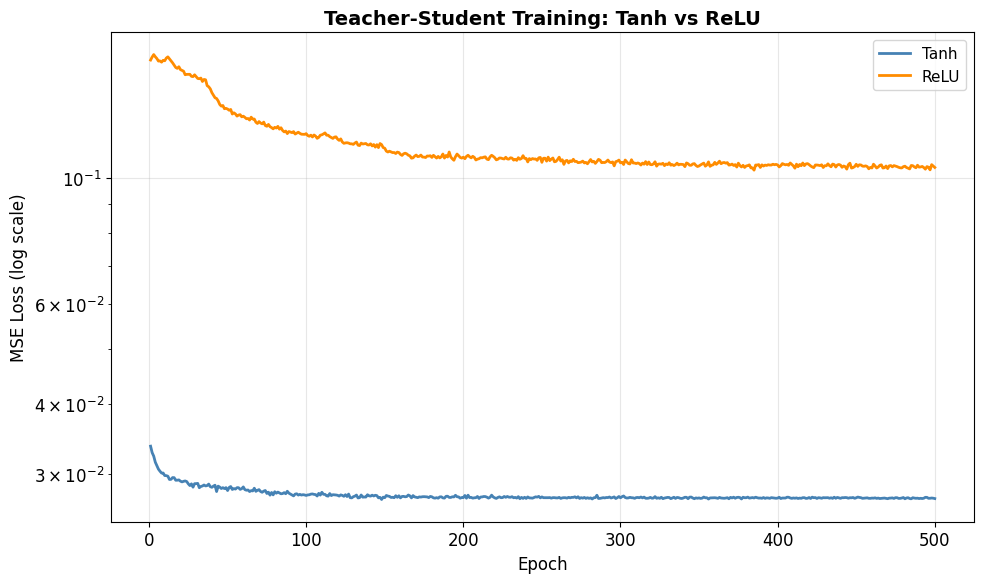


Final loss - Tanh: 0.027185
Final loss - ReLU: 0.104452


In [245]:
# Plot loss curves
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

epochs = np.arange(1, N_EPOCHS + 1)

ax.semilogy(epochs, losses_tanh, label="Tanh", linewidth=2, color="steelblue")
ax.semilogy(epochs, losses_relu, label="ReLU", linewidth=2, color="darkorange")

ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("MSE Loss (log scale)", fontsize=12)
ax.set_title("Teacher-Student Training: Tanh vs ReLU", fontsize=14, fontweight="bold")
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal loss - Tanh: {losses_tanh[-1]:.6f}")
print(f"Final loss - ReLU: {losses_relu[-1]:.6f}")

## 6. Compare Phase Portraits: Before vs After Training


In [246]:
# Create fresh student (before training) for comparison
_, student_tanh_init = create_teacher_student_pair(
    NUM_NEURONS, nn.Tanh, teacher_seed=TEACHER_SEED, student_alpha_seed=STUDENT_ALPHA_SEED
)
_, student_relu_init = create_teacher_student_pair(
    NUM_NEURONS, nn.ReLU, teacher_seed=TEACHER_SEED, student_alpha_seed=STUDENT_ALPHA_SEED
)

# Generate test trajectories for visual comparison
torch.manual_seed(999)
n_test = 6
r0_test = torch.randn(n_test, NUM_NEURONS) * 2

with torch.no_grad():
    # Tanh trajectories
    trajs_teacher_tanh = [teacher_tanh.unroll(r0_test[i:i+1], T).squeeze(0) for i in range(n_test)]
    trajs_student_tanh_init = [student_tanh_init.unroll(r0_test[i:i+1], T).squeeze(0) for i in range(n_test)]
    trajs_student_tanh_trained = [student_tanh.unroll(r0_test[i:i+1], T).squeeze(0) for i in range(n_test)]
    
    # ReLU trajectories
    trajs_teacher_relu = [teacher_relu.unroll(r0_test[i:i+1], T).squeeze(0) for i in range(n_test)]
    trajs_student_relu_init = [student_relu_init.unroll(r0_test[i:i+1], T).squeeze(0) for i in range(n_test)]
    trajs_student_relu_trained = [student_relu.unroll(r0_test[i:i+1], T).squeeze(0) for i in range(n_test)]

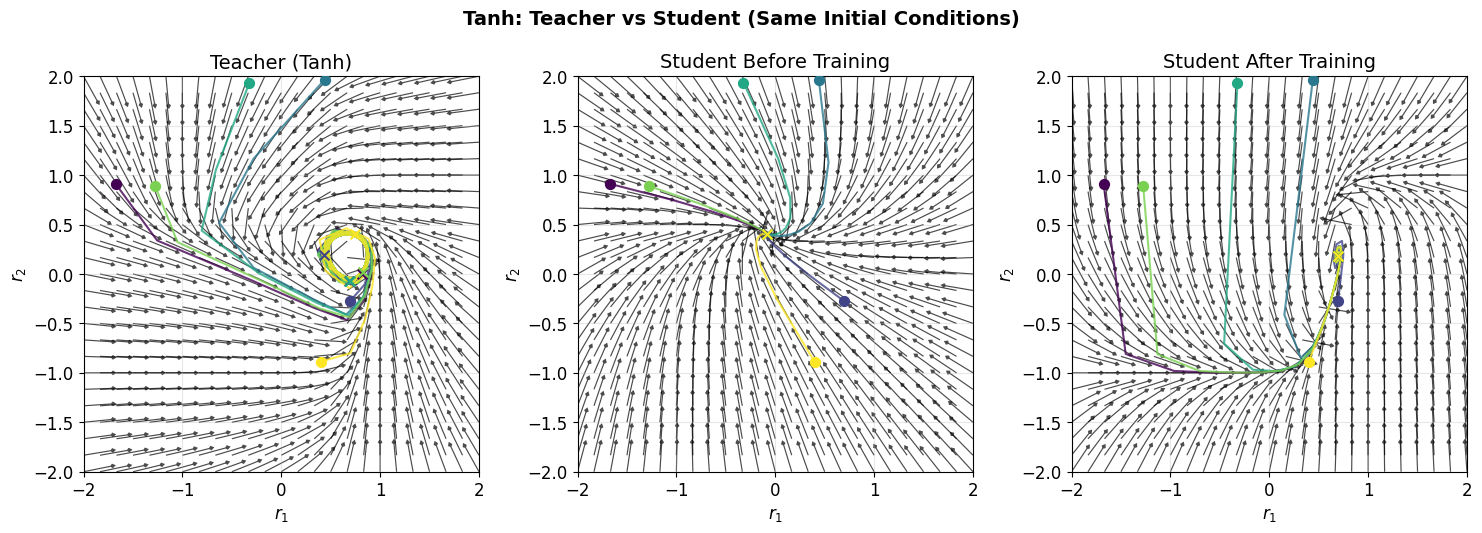

In [247]:
# Plot comparison for Tanh
if NUM_NEURONS == 2:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plot_phase_portrait(teacher_tanh, axes[0], trajectories=trajs_teacher_tanh, title="Teacher (Tanh)")
    plot_phase_portrait(student_tanh_init, axes[1], trajectories=trajs_student_tanh_init, title="Student Before Training")
    plot_phase_portrait(student_tanh, axes[2], trajectories=trajs_student_tanh_trained, title="Student After Training")
elif NUM_NEURONS == 3:
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    plot_phase_portrait(teacher_tanh, ax1, trajectories=trajs_teacher_tanh, title="Teacher (Tanh)")
    plot_phase_portrait(student_tanh_init, ax2, trajectories=trajs_student_tanh_init, title="Student Before Training")
    plot_phase_portrait(student_tanh, ax3, trajectories=trajs_student_tanh_trained, title="Student After Training")
else:
    print(f"Cannot visualize {NUM_NEURONS}D phase portraits")

plt.suptitle("Tanh: Teacher vs Student (Same Initial Conditions)", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

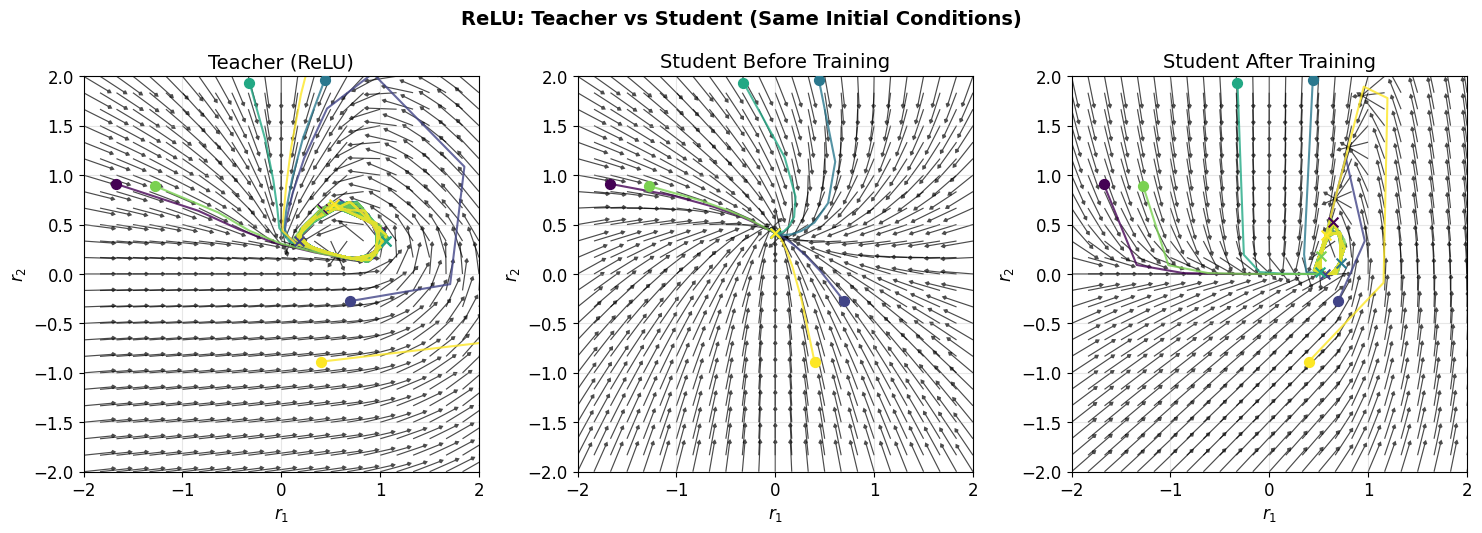

In [248]:
# Plot comparison for ReLU
if NUM_NEURONS == 2:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    plot_phase_portrait(teacher_relu, axes[0], trajectories=trajs_teacher_relu, title="Teacher (ReLU)")
    plot_phase_portrait(student_relu_init, axes[1], trajectories=trajs_student_relu_init, title="Student Before Training")
    plot_phase_portrait(student_relu, axes[2], trajectories=trajs_student_relu_trained, title="Student After Training")
elif NUM_NEURONS == 3:
    fig = plt.figure(figsize=(18, 6))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    plot_phase_portrait(teacher_relu, ax1, trajectories=trajs_teacher_relu, title="Teacher (ReLU)")
    plot_phase_portrait(student_relu_init, ax2, trajectories=trajs_student_relu_init, title="Student Before Training")
    plot_phase_portrait(student_relu, ax3, trajectories=trajs_student_relu_trained, title="Student After Training")
else:
    print(f"Cannot visualize {NUM_NEURONS}D phase portraits")

plt.suptitle("ReLU: Teacher vs Student (Same Initial Conditions)", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

## 6b. Compare Loss Types: Trajectory vs Vector Field

Train students using **vector field loss** instead of trajectory loss, then compare.

In [251]:
# === Train with Vector Field Loss ===

# Create fresh teacher-student pairs for vector field training
teacher_tanh_vf, student_tanh_vf = create_teacher_student_pair(
    NUM_NEURONS, nn.Tanh,
    custom_W=custom_W if NUM_NEURONS == 2 else None,
    custom_b=custom_b if NUM_NEURONS == 2 else None,
    custom_teacher_alphas=custom_alphas if NUM_NEURONS == 2 else None,
)
teacher_relu_vf, student_relu_vf = create_teacher_student_pair(
    NUM_NEURONS, nn.ReLU,
    custom_W=custom_W if NUM_NEURONS == 2 else None,
    custom_b=custom_b if NUM_NEURONS == 2 else None,
    custom_teacher_alphas=custom_alphas if NUM_NEURONS == 2 else None,
)

print("=" * 60)
print("Training Tanh Student (Vector Field Loss)")
print("=" * 60)
losses_tanh_vf = train_student_vectorfield(
    teacher_tanh_vf, student_tanh_vf,
    n_epochs=N_EPOCHS,
    n_samples=BATCH_SIZE * 4,  # More samples since it's cheaper
    sample_scale=3.0,
    lr=LR,
)

print()
print("=" * 60)
print("Training ReLU Student (Vector Field Loss)")
print("=" * 60)
losses_relu_vf = train_student_vectorfield(
    teacher_relu_vf, student_relu_vf,
    n_epochs=N_EPOCHS,
    n_samples=BATCH_SIZE * 4,
    sample_scale=3.0,
    lr=LR,
)

Training Tanh Student (Vector Field Loss)
Epoch  100 | VF Loss: 0.386523
Epoch  200 | VF Loss: 0.339536
Epoch  300 | VF Loss: 0.403100
Epoch  400 | VF Loss: 0.358125
Epoch  500 | VF Loss: 0.377416

Training ReLU Student (Vector Field Loss)
Epoch  100 | VF Loss: 0.596378
Epoch  200 | VF Loss: 0.404690
Epoch  300 | VF Loss: 0.395609
Epoch  400 | VF Loss: 0.419886
Epoch  500 | VF Loss: 0.429566


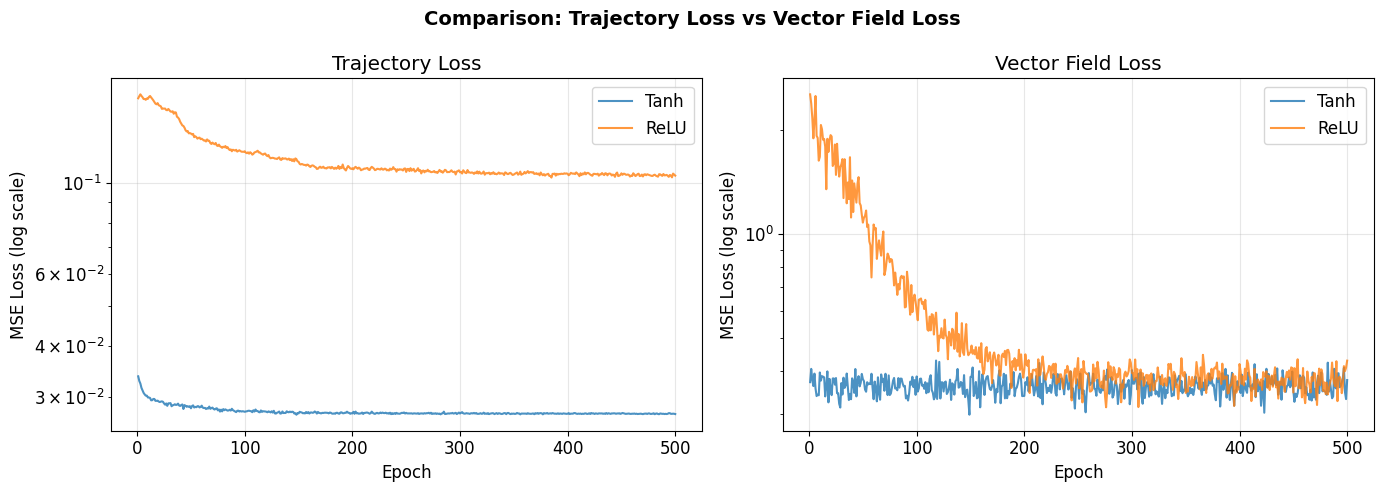


Final Loss Comparison
Method                               Tanh            ReLU
-------------------------------------------------------
Trajectory Loss                  0.027185        0.104452
Vector Field Loss                0.377416        0.429566


In [252]:
# === Compare Loss Curves: Trajectory vs Vector Field ===

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = np.arange(1, N_EPOCHS + 1)

# Left: Trajectory Loss
ax = axes[0]
ax.semilogy(epochs, losses_tanh, label="Tanh", color="tab:blue", alpha=0.8)
ax.semilogy(epochs, losses_relu, label="ReLU", color="tab:orange", alpha=0.8)
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss (log scale)")
ax.set_title("Trajectory Loss")
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Vector Field Loss
ax = axes[1]
ax.semilogy(epochs, losses_tanh_vf, label="Tanh", color="tab:blue", alpha=0.8)
ax.semilogy(epochs, losses_relu_vf, label="ReLU", color="tab:orange", alpha=0.8)
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss (log scale)")
ax.set_title("Vector Field Loss")
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle("Comparison: Trajectory Loss vs Vector Field Loss", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

# Print final losses
print("\n" + "=" * 60)
print("Final Loss Comparison")
print("=" * 60)
print(f"{'Method':<25} {'Tanh':>15} {'ReLU':>15}")
print("-" * 55)
print(f"{'Trajectory Loss':<25} {losses_tanh[-1]:>15.6f} {losses_relu[-1]:>15.6f}")
print(f"{'Vector Field Loss':<25} {losses_tanh_vf[-1]:>15.6f} {losses_relu_vf[-1]:>15.6f}")

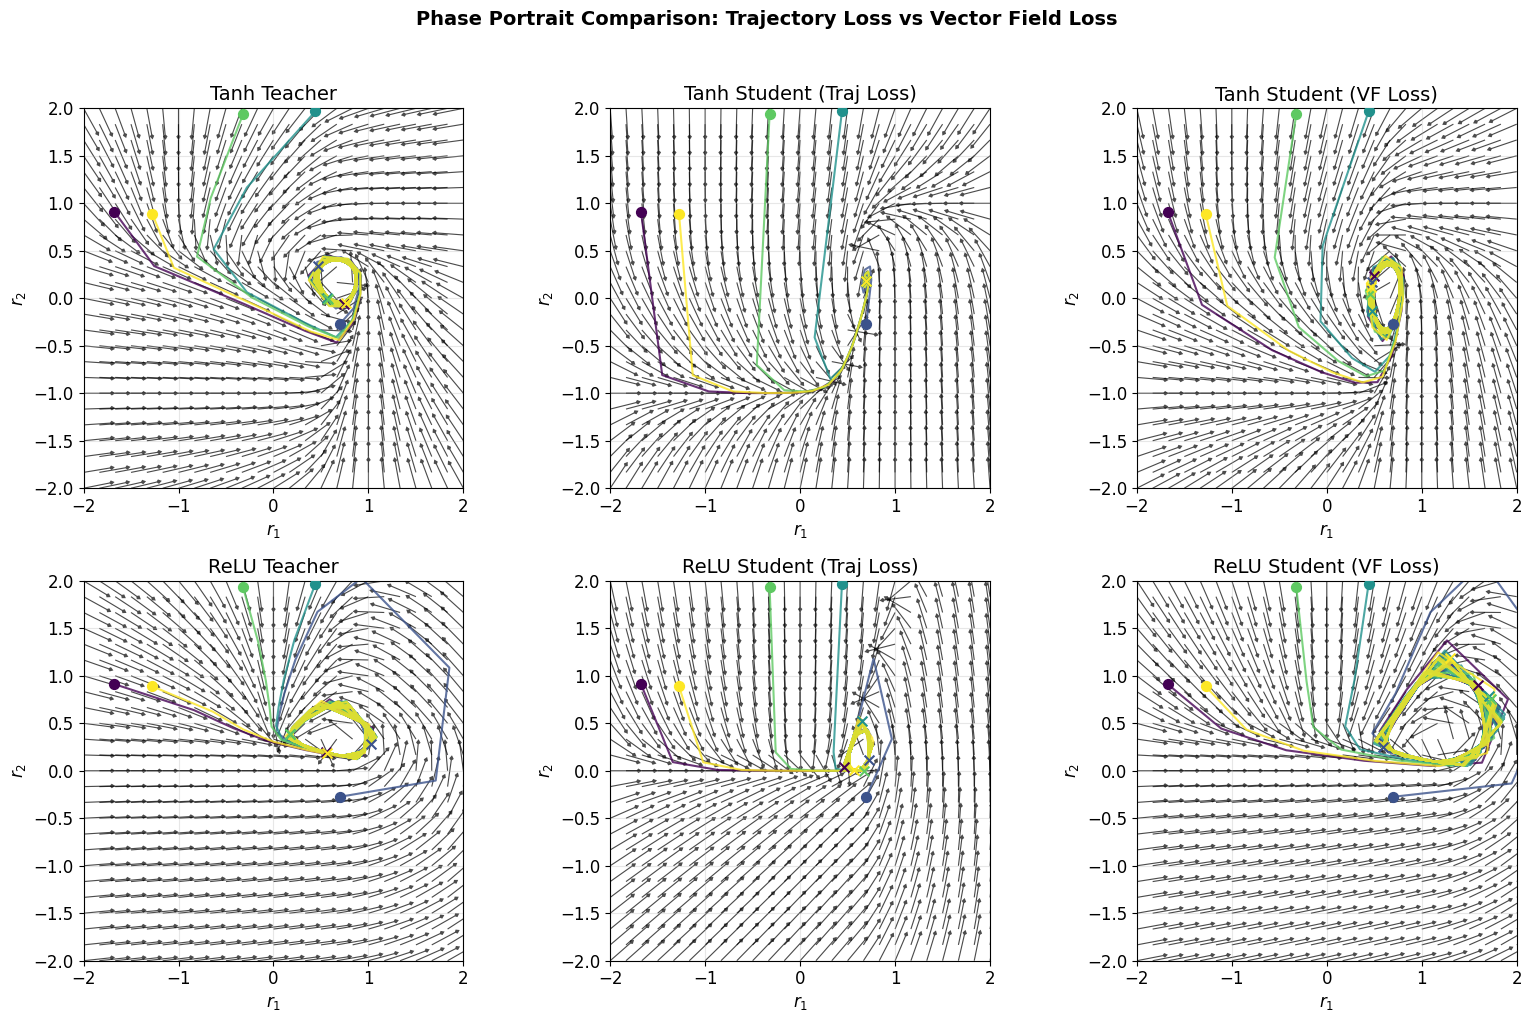

In [254]:
# === Compare Phase Portraits: Trajectory-trained vs VF-trained ===

if NUM_NEURONS == 2:
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    
    lim = 2.0
    
    # Generate trajectories for comparison
    torch.manual_seed(999)
    n_traj = 5
    r0_compare = torch.randn(n_traj, 2) * 2.0
    T_compare = 100
    
    with torch.no_grad():
        trajs_teacher_tanh = [teacher_tanh.unroll(r0_compare[i:i+1], T_compare).squeeze(0) for i in range(n_traj)]
        trajs_student_tanh_traj = [student_tanh.unroll(r0_compare[i:i+1], T_compare).squeeze(0) for i in range(n_traj)]
        trajs_student_tanh_vf = [student_tanh_vf.unroll(r0_compare[i:i+1], T_compare).squeeze(0) for i in range(n_traj)]
        
        trajs_teacher_relu = [teacher_relu.unroll(r0_compare[i:i+1], T_compare).squeeze(0) for i in range(n_traj)]
        trajs_student_relu_traj = [student_relu.unroll(r0_compare[i:i+1], T_compare).squeeze(0) for i in range(n_traj)]
        trajs_student_relu_vf = [student_relu_vf.unroll(r0_compare[i:i+1], T_compare).squeeze(0) for i in range(n_traj)]
    
    # Row 1: Tanh
    plot_phase_portrait_2d(teacher_tanh, axes[0, 0], (-lim, lim), (-lim, lim), 
                           trajectories=trajs_teacher_tanh, title="Tanh Teacher")
    plot_phase_portrait_2d(student_tanh, axes[0, 1], (-lim, lim), (-lim, lim),
                           trajectories=trajs_student_tanh_traj, title="Tanh Student (Traj Loss)")
    plot_phase_portrait_2d(student_tanh_vf, axes[0, 2], (-lim, lim), (-lim, lim),
                           trajectories=trajs_student_tanh_vf, title="Tanh Student (VF Loss)")
    
    # Row 2: ReLU
    plot_phase_portrait_2d(teacher_relu, axes[1, 0], (-lim, lim), (-lim, lim),
                           trajectories=trajs_teacher_relu, title="ReLU Teacher")
    plot_phase_portrait_2d(student_relu, axes[1, 1], (-lim, lim), (-lim, lim),
                           trajectories=trajs_student_relu_traj, title="ReLU Student (Traj Loss)")
    plot_phase_portrait_2d(student_relu_vf, axes[1, 2], (-lim, lim), (-lim, lim),
                           trajectories=trajs_student_relu_vf, title="ReLU Student (VF Loss)")
    
    plt.suptitle("Phase Portrait Comparison: Trajectory Loss vs Vector Field Loss", 
                 fontsize=14, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Phase portrait comparison only shown for NUM_NEURONS=2")

## 7. Summary


In [249]:
print("=" * 70)
print("SUMMARY")
print("=" * 70)

print("\n--- Network Configuration ---")
print(f"Number of neurons: {NUM_NEURONS}")
print(f"Trajectory length T: {T}")
print(f"Training epochs: {N_EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LR}")

# Format alphas
teacher_alpha_str = ", ".join([f"{a:.4f}" for a in teacher_tanh.alphas])
student_alpha_str = ", ".join([f"{a:.4f}" for a in student_tanh.alphas])

print("\n--- Teacher Alphas (same for both activations) ---")
print(f"α = [{teacher_alpha_str}]")

print("\n--- Student Alphas (same for both activations) ---")
print(f"α = [{student_alpha_str}]")

print("\n--- Final Training Loss ---")
print(f"Tanh: {losses_tanh[-1]:.6f}")
print(f"ReLU: {losses_relu[-1]:.6f}")

print("\n--- Learned Weights (Student After Training) ---")
print("\nTanh Student W_rec:")
print(student_tanh.W_rec.weight.data.numpy())
print(f"Bias: {student_tanh.W_rec.bias.data.numpy()}")

print("\nReLU Student W_rec:")
print(student_relu.W_rec.weight.data.numpy())
print(f"Bias: {student_relu.W_rec.bias.data.numpy()}")

print("\n--- Teacher Weights (for reference) ---")
print("\nTeacher W_rec:")
print(teacher_tanh.W_rec.weight.data.numpy())
print(f"Bias: {teacher_tanh.W_rec.bias.data.numpy()}")

SUMMARY

--- Network Configuration ---
Number of neurons: 2
Trajectory length T: 60
Training epochs: 500
Batch size: 64
Learning rate: 0.01

--- Teacher Alphas (same for both activations) ---
α = [0.5000, 0.3000]

--- Student Alphas (same for both activations) ---
α = [0.2000, 0.9000]

--- Final Training Loss ---
Tanh: 0.027185
ReLU: 0.104452

--- Learned Weights (Student After Training) ---

Tanh Student W_rec:
[[-0.116     -2.4222047]
 [ 3.178985  -0.116    ]]
Bias: [ 1.3873042 -1.9943568]

ReLU Student W_rec:
[[-0.116     -3.4432948]
 [ 3.4935439 -0.116    ]]
Bias: [ 1.181639  -2.0619833]

--- Teacher Weights (for reference) ---

Teacher W_rec:
[[-0.116     -3.5400002]
 [ 3.5400002 -0.116    ]]
Bias: [ 1.83 -2.2 ]
